<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/NMDAExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Stylized-Cell-model/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Stylized-Cell-model


In [3]:
array = [True, True, False, False, True, False]

print(True +  True) 
print(False + True)
print(True + False)
print(False + False)


print(np.diff((array), prepend = False))

2
1
1
0
[ True False  True False  True  True]


In [4]:

# for p in segs[(segs.Type=='dend')].index:
#   threshold_crossings = np.diff(v['report']['biophysical']['data'][:,15] > -40, prepend=False)
#   upward_crossings = np.argwhere(threshold_crossings)[::2,0]
#   print(p)
#   if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
#     legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>260]
#     print('if')
#   else:
#     legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>260]
#     print('else')



# print(legit_up_crossings)

In [85]:
def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    #print('volt')
    #print(threshold_crossings)
    #print(upward_crossings)
    #print(downward_crossings)
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        #print('if')
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        #print('else')
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current



In [6]:
output_folder = 'output_control'

conns = pd.read_csv('./{}/Connections.csv'.format(output_folder))


In [7]:
conns.head()

,Node ID,Distance,Conductance,Type,Name,Source Population,Release Probability
0,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.7338849377164783),dist_inh_stim,0.919775
1,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.8115924678523401),dist_inh_stim,0.866709
2,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.5772963343810508),dist_inh_stim,0.870135
3,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.38323942469696737),dist_inh_stim,0.874873
4,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.23996958856057937),dist_inh_stim,0.897784


In [8]:
#print(conns)

In [9]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))

In [10]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))

conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

In [11]:
conns.head()

,Node ID,conns_Distance,Conductance,Type,Name,Source Population,Release Probability,Sec ID,X
0,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.7338849377164783),dist_inh_stim,0.919775,0,0.733885
1,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.8115924678523401),dist_inh_stim,0.866709,0,0.811592
2,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.5772963343810508),dist_inh_stim,0.870135,0,0.577296
3,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.38323942469696737),dist_inh_stim,0.874873,0,0.383239
4,0,10.0,1.0,dend,L5PCtemplate[0].dend[0](0.23996958856057937),dist_inh_stim,0.897784,0,0.239970


In [ ]:
segs = pd.read_csv('L5Segments.csv')
# segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Sec ID','Type'])['Degrees'].max().reset_index()
# #print(segs)
# print(segs_degrees)
# segs['segmentID'] = segs.index
# segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False, duplicates = 'drop')
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False, duplicates = 'drop')

In [13]:
exc_syns_per_seg = conns[conns['Source Population']=='exc_stim'].groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})




In [14]:
exc_syns_per_seg.head()

,Type,Sec ID,X,num_syns
0,apic,12,0.875534,1
1,apic,12,0.878328,1
2,apic,12,0.879931,1
3,apic,12,0.880013,1
4,apic,12,0.881852,1


In [15]:
segs['segmentID'] = segs.groupby(['Type','Sec ID']).cumcount()+1

In [16]:
exc_syns_per_seg['segmentID'] = exc_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1

In [17]:
exc_syns = segs.set_index(['Type','Sec ID','segmentID']).join(exc_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()


In [18]:
v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')


v['report']['biophysical']['data'][:]

array([[-72.        , -72.        , -72.        , ..., -72.        ,
        -72.        , -72.        ],
       [-72.01509207, -72.01062107, -72.00601079, ..., -72.0107143 ,
        -72.00720916, -72.0107143 ],
       [-72.02530576, -72.02007588, -72.01371607, ..., -72.02067277,
        -72.01640999, -72.02067277],
       ...,
       [-59.0469658 , -57.56612813, -54.77052824, ..., -59.03060606,
        -59.05146606, -59.03060606],
       [-58.98377064, -57.42746418, -54.48347532, ..., -58.96973879,
        -58.99330032, -58.96973879],
       [-58.91905389, -57.30852354, -54.25961039, ..., -58.90616144,
        -58.93121756, -58.90616144]])

In [19]:
v['report']['biophysical']['data'][:-100,1]

array([-72.        , -72.01062107, -72.02007588, ..., -58.00416753,
       -57.98184793, -57.96522491])

In [20]:
v_thresh = -40
np.diff(v['report']['biophysical']['data'][:-10000,1]> v_thresh, prepend=False)

array([False, False, False, ..., False, False, False])

In [21]:
spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [22]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    #print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > (0.003/1000), prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        na_df = na_df.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
                                               'na_lower_bound':na_spks}))
    else:
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':np.array([np.nan])}))

In [23]:
na_df.to_csv('na_df.csv')
na_df = pd.read_csv('na_df.csv')


na_df.index

RangeIndex(start=0, stop=2529, step=1)

In [24]:

display(na_df.to_string())

'      Unnamed: 0  segmentID  na_lower_bound\n0              0          0           564.0\n1              1          0           915.0\n2              2          0           983.0\n3              3          0          1342.0\n4              4          0          1505.0\n5              5          0          1715.0\n6              6          0          1906.0\n7              7          0          2117.0\n8              8          0          2349.0\n9              9          0          2767.0\n10            10          0          3200.0\n11            11          0          4203.0\n12            12          0          4622.0\n13            13          0          5064.0\n14            14          0          5118.0\n15            15          0          5619.0\n16            16          0          6134.0\n17            17          0          6613.0\n18            18          0          6827.0\n19            19          0          7092.0\n20            20          0          7454.0\n21       

In [25]:
for i in np.random.choice(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)].index,10):
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        
        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [26]:
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [27]:
segs_na_df = segs.join(na_df.set_index('segmentID')).reset_index()
# display(segs_na_df.Type.to_string())
# display(segs_na_df.Elec_distance.to_string())


na_df.head



segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&(segs_na_df.Type=='apic')]

,index,BMTK ID,X,Type,Sec ID,Distance,Coord X,Coord Y,Coord Z,Elec_distance,Elec_distanceQ,segmentID,Unnamed: 0,na_lower_bound,duration_low,duration_high,peak_value,duration
795,48,48,0.937500,apic,13,10.000000,0.000000e+00,0.000000,0.000000,0.999988,9,1,0,527.0,NaN,NaN,NaN,NaN
796,48,48,0.937500,apic,13,10.000000,0.000000e+00,0.000000,0.000000,0.999988,9,1,1,813.0,NaN,NaN,NaN,NaN
797,48,48,0.937500,apic,13,10.000000,0.000000e+00,0.000000,0.000000,0.999988,9,1,2,1126.0,NaN,NaN,NaN,NaN
798,48,48,0.937500,apic,13,10.000000,0.000000e+00,0.000000,0.000000,0.999988,9,1,3,1195.0,NaN,NaN,NaN,NaN
799,48,48,0.937500,apic,13,10.000000,0.000000e+00,0.000000,0.000000,0.999988,9,1,4,2518.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,174,174,0.357143,apic,31,1379.999970,-1.996837e-14,1355.689148,-108.702759,0.004319,0,4,0,571.0,NaN,NaN,NaN,NaN
2446,175,175,0.500000,apic,31,1409.999972,-2.163240e-14,1389.496582,-117.761322,0.003807,0,5,0,573.0,NaN,NaN,NaN,NaN
2447,176,176,0.642857,apic,31,1439.999974,-2.329643e-14,1423.304016,-126.819885,0.003372,0,6,0,573.0,NaN,NaN,NaN,NaN
2448,176,176,0.642857,apic,31,1439.999974,-2.329643e-14,1423.304016,-126.819885,0.003372,0,6,1,5309.0,NaN,NaN,NaN,NaN


In [28]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#print(na_df)

In [29]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
   # print(edges_dend)
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
   # print('please')
    actual_spktimes = []
    c = 0

   # print(spktimes)


    for i in np.sort(spktimes):
        # excludes bursts
        #print(i)
        if i-c > 10:
            for e in np.arange(0,10):
                #print(e)
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
                #print(na_inds)
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    

    
    
    return na_dend, na_apic

In [30]:
na_dend, na_apic = get_sta(segs_na_df, spktimes)

In [31]:
print(na_apic)

[[ 0.  0.  0.  1.  0.  0.  1.  3.  0.  1.  0.  0.  1.  5.  5.  1.  7.  3.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.]
 [ 4.  4.  4.  4.  1.  6.  7.  5.  4.  4.  3.  6.  7.  5.  9.  7.  3. 11.
   4.  4.  0.  0.  0.  0.  0.  4.  2.  1.  3.  3.  6.  4.  0.  1.  1.  3.
   5.  3. 10.]
 [ 1.  1.  1.  3.  1.  0.  1.  2.  1.  1.  2.  4.  0.  2.  2.  2.  8. 12.
   6.  2.  0.  0.  0.  0.  0.  0.  4.  6.  2.  2.  5.  3.  3.  6.  2.  3.
   7.  4.  8.]
 [ 2.  1.  0.  0.  2.  2.  0.  0.  1.  2.  1.  0.  0.  2.  2.  1.  1.  1.
   1.  2.  1.  0.  0.  0.  0.  2.  3.  1.  2.  3.  1.  0.  1.  0.  0.  3.
   0.  2.  0.]
 [ 4.  2.  3.  3.  5.  5.  6.  5.  5.  0.  7.  9.  4.  5.  3.  3.  4.  1.
   1.  4.  1.  0.  0.  0.  0.  3.  2.  3.  4.  4.  5.  6.  1.  5.  7.  2.
   5.  6.  8.]
 [ 5.  4.  3.  1.  2.  6.  8.  3.  1.  2.  5.  5.  5.  2.  4.  3.  3.  2.
   3.  5.  1.  0.  0.  0.  0.  1.  2.  0.  1.  6.  1.  3.  1.  5.  5.  2.
   4.  9.  7.]
 [ 4.  1.  5.  4.  4. 

In [32]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [33]:
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

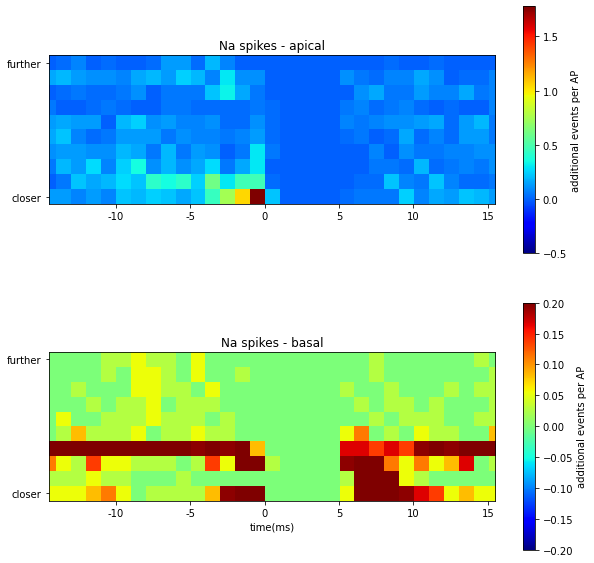

In [34]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow((na_apic-na_apic_rand)/len(spktimes),cmap='jet',vmin=-0.5)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2, vmax=0.2)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

----------

In [35]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])

segIDs = segs[(segs.Type=='apic')]['segmentID']
for p in segIDs:
    #print(p)
    trace = hva['report']['biophysical']['data'][:,p]+\
                lva['report']['biophysical']['data'][:,p]+\
                ih['report']['biophysical']['data'][:,p]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=200)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc

    print(legit_dc_iso)
    
    
    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=hva['report']['biophysical']['data'])
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan}))

else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
if
if
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[10725]
if
if
[  882  1848  2584  4180  5501  6445  7463  8016  8663  9761 10203 10731
 11218 12248 13016 13466 14439]
if
if
[  939  1881  2715  3552  4281  5009  5895  7046  8048  8679 11548 11861
 12355 13087 14448]
if
if
[  969  1946  3588  5908  7053  8061  8792 12367 14460]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
else
else
[]
if
if
[]
else
else
[]
els

In [36]:
#print(ca_df)

In [37]:
ca_df.to_csv('ca_df.csv')
ca_df = pd.read_csv('ca_df.csv')

# durations

In [38]:
segs[(segs['Coord Y']>600)&(segs['Coord Y']<800)]

,BMTK ID,X,Type,Sec ID,Distance,Coord X,Coord Y,Coord Z,Elec_distance,Elec_distanceQ,segmentID
93,93,0.815789,apic,18,617.552632,0.0,618.666667,0.0,0.263468,6,17
94,94,0.868421,apic,18,646.131579,0.0,648.833333,0.0,0.247892,6,18
95,95,0.921053,apic,18,689.000000,0.0,679.000000,0.0,0.226892,6,19
96,96,0.973684,apic,19,689.000000,0.0,679.000000,0.0,0.226892,6,1
97,97,0.050000,apic,19,729.650000,0.0,709.111111,0.0,0.201364,6,2
98,98,0.150000,apic,19,756.750000,0.0,739.222222,0.0,0.186645,6,3
99,99,0.250000,apic,19,783.850000,0.0,769.333333,0.0,0.173479,6,4
100,100,0.350000,apic,19,810.950000,0.0,799.444444,0.0,0.161651,5,5


In [39]:
np.random.choice(segs[(segs['Coord Y']<-50)&
     (segs['Coord Y']>-100)&
     (segs['Coord X']>-50)&
     (segs['Coord X']<50)&
     (segs['Type']=='dend')]['segmentID'])

2

## Plotting morphology as heat maps

In [40]:
exc_syns.shape

(188, 12)

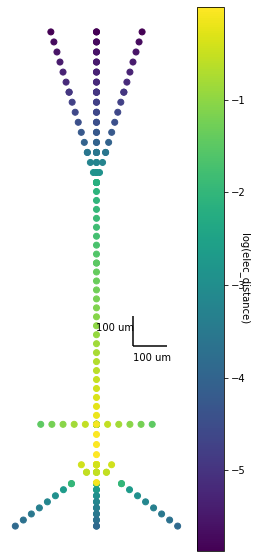

In [41]:
plt.figure(figsize=(4,10))
ax = plt.scatter(exc_syns['Coord X'], exc_syns['Coord Y'],c=np.log(exc_syns['Elec_distance']))
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

In [42]:
exc_syns.loc[pd.isnull(exc_syns.num_syns),'num_syns'] = 0

In [43]:
exc_syns[exc_syns.num_syns==0].shape, exc_syns[exc_syns.num_syns!=0].shape

((39, 12), (149, 12))

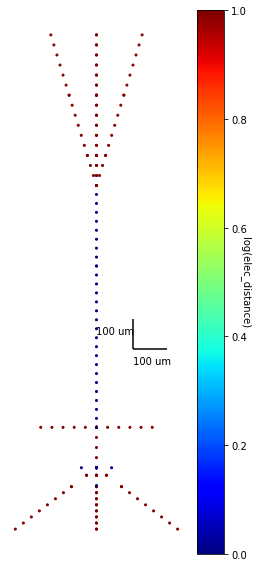

In [44]:
plt.figure(figsize=(4,10))
ax = plt.scatter(exc_syns['Coord X'], exc_syns['Coord Y'],c=exc_syns['num_syns'],s=4,cmap='jet')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

## Plotting morphology and voltage traces

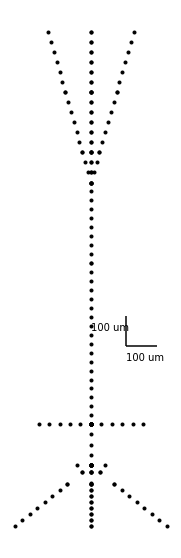

In [45]:
plt.figure(figsize=(3,10))
ax = plt.plot(segs['Coord X'], segs['Coord Y'],'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(segs.loc[segs.segmentID==1959,'Coord X'], 
         segs.loc[segs.segmentID==1959,'Coord Y'],
         'r*')
plt.plot(segs.loc[segs.segmentID==1112,'Coord X'], 
         segs.loc[segs.segmentID==1112,'Coord Y'],
         'b*')
plt.plot(segs.loc[segs.segmentID==1046,'Coord X'], 
         segs.loc[segs.segmentID==1046,'Coord Y'],
         'm*')
plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
         segs.loc[segs.segmentID==1500,'Coord Y'],
         'g*')
plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
         segs.loc[segs.segmentID==680,'Coord Y'],
         '*',color='orange')
plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
         segs.loc[segs.segmentID==482,'Coord Y'],
         '*',color='grey')
plt.savefig('fig1A.svg')

In [46]:
#v = h5py.File('../../../L5NeuronSimulation_expts/L5_control/L5_control_exc_med/L5NeuronSimulation/FullSimulation/output/v_report.h5','r')


In [47]:
#t

2


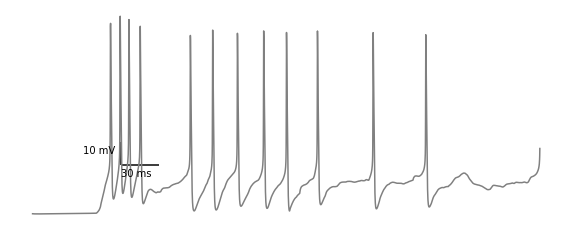

In [48]:
t = np.random.choice(segs[(segs['Coord Y']<-50)&
     (segs['Coord Y']>-100)&
     (segs['Coord X']>-50)&
     (segs['Coord X']<50)&
     (segs['Type']=='dend')]['segmentID'])

print(t)

plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='grey')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2G.svg')

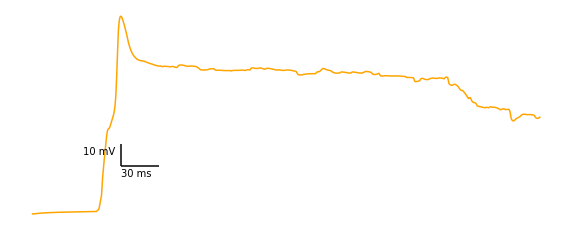

In [49]:
plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,130],color='orange')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2F.svg')

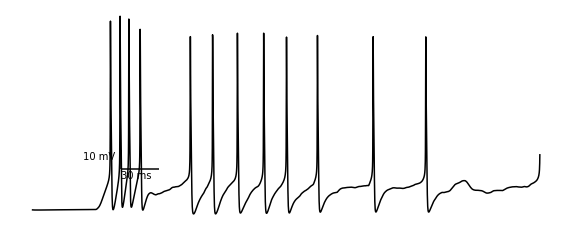

In [50]:
plt.figure(figsize=(10,4))
s1 = 3 #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2E.svg')

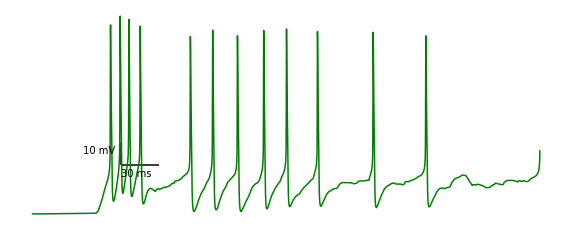

In [51]:
plt.figure(figsize=(10,4))
s1 =  3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000, 4],color='g')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2C.svg')

In [52]:
# plt.figure(figsize=(10,4))
# #s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
# plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,3],color='m')
# #1433413, 1161455
# plt.hlines(-50,70,100)
# plt.text(70,-55,'30 ms')
# plt.vlines(70,-50,-40)
# plt.text(40,-45,'10 mV')
# plt.box(False)
# plt.xticks([])
# plt.yticks([])
# plt.savefig('fig2D.svg')

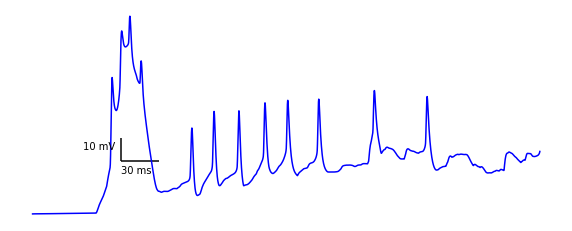

In [53]:
plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,70],color='b')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2B.svg')

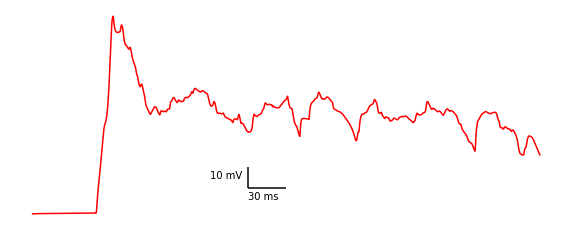

In [54]:
plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000, 30],color='r')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'30 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2A.svg')

In [55]:
s1

3

([], <a list of 0 Text major ticklabel objects>)

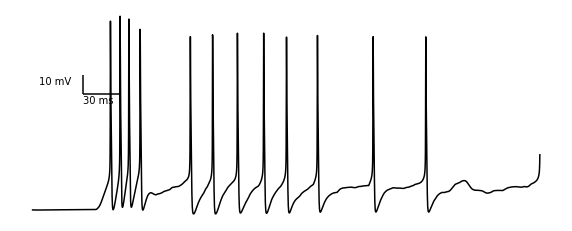

In [56]:
plt.figure(figsize=(10,4))
#s1 = 559133+1000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-10,40,70)
plt.text(40,-15,'30 ms')
plt.vlines(40,-10,0)
plt.text(5,-5,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [57]:
# x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
# i = np.random.choice(x.index)

(0.0, 200.0)

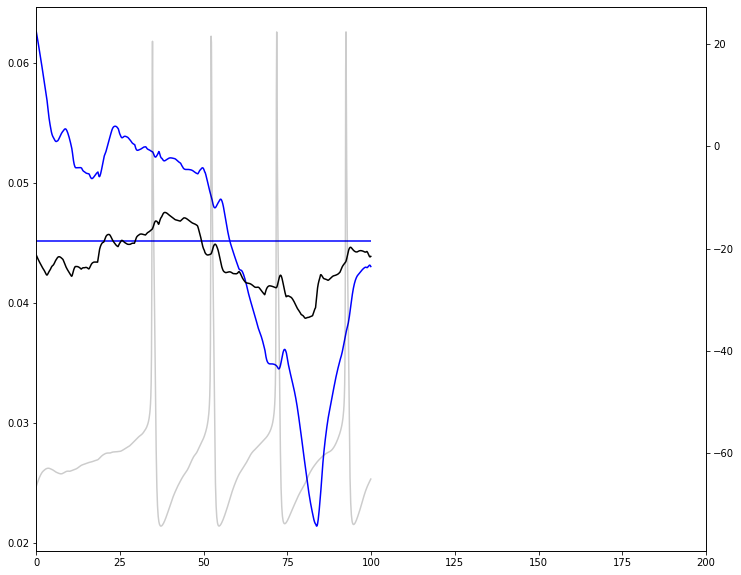

In [58]:
seg = 30
lower_bound = 1000
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,100,.1),-(hva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         lva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         ih['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]),color='b')
plt.hlines(np.mean(-(hva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         lva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         ih['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg])),0,100,color='b')
plt.xlim(0,200)

plt.twinx()
plt.plot(np.arange(0,100,.1),v['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg],color='k')
plt.plot(np.arange(0,100,.1),v['report']['biophysical']['data'][lower_bound-100:lower_bound+900,0],color='k',alpha=0.2)
plt.xlim(0,200)


In [59]:
ca_df.reset_index(inplace=True)


In [60]:
ca_df

,index,Unnamed: 0,segmentID,ca_lower_bound,ca_upper_bound,mag
0,0,0,1,NaN,NaN,NaN
1,1,0,2,NaN,NaN,NaN
2,2,0,3,NaN,NaN,NaN
3,3,0,4,NaN,NaN,NaN
4,4,0,5,NaN,NaN,NaN
...,...,...,...,...,...,...
162,162,0,3,NaN,NaN,NaN
163,163,0,4,NaN,NaN,NaN
164,164,0,5,NaN,NaN,NaN
165,165,0,6,NaN,NaN,NaN


In [61]:
ca_df[(ca_df.ca_lower_bound>20) & (ca_df.ca_lower_bound<1400000)]

,index,Unnamed: 0,segmentID,ca_lower_bound,ca_upper_bound,mag
44,44,0,16,10455.0,10725.0,-0.398541
45,45,0,17,574.0,882.0,-1.690168
46,46,1,17,1529.0,1848.0,-0.763176
47,47,2,17,3919.0,4180.0,-0.378574
48,48,3,17,5252.0,5501.0,-0.378509
49,49,4,17,6006.0,6445.0,-0.332711
50,50,5,17,7281.0,7463.0,-0.272167
51,51,6,17,7671.0,8016.0,-0.220607
52,52,7,17,8210.0,8663.0,-0.550593
53,53,8,17,9178.0,9761.0,-0.388495


In [62]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>20) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        
        trace = -(hva['report']['biophysical']['data'][spkt-100:spkt+200,seg] + \
                lva['report']['biophysical']['data'][spkt-100:spkt+200,seg] + \
                ih['report']['biophysical']['data'][spkt-100:spkt+200,seg])
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,300)[trace>half_peak] + spkt - 10
        ca_df.loc[i,'duration_low'] = duration[0]
        ca_df.loc[i,'duration_high'] = duration[-1]
        ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

In [63]:
ca_df[~pd.isnull(ca_df.duration_high)]

,index,Unnamed: 0,segmentID,ca_lower_bound,ca_upper_bound,mag,duration_low,duration_high,peak_value
44,44,0,16,10455.0,10725.0,-0.398541,10595.0,10649.0,0.033386
45,45,0,17,574.0,882.0,-1.690168,711.0,863.0,0.085189
46,46,1,17,1529.0,1848.0,-0.763176,1693.0,1794.0,0.052265
47,47,2,17,3919.0,4180.0,-0.378574,4099.0,4165.0,0.040075
48,48,3,17,5252.0,5501.0,-0.378509,5499.0,5541.0,0.038710
50,50,5,17,7281.0,7463.0,-0.272167,7459.0,7526.0,0.029643
51,51,6,17,7671.0,8016.0,-0.220607,7914.0,7960.0,0.011369
52,52,7,17,8210.0,8663.0,-0.550593,8459.0,8499.0,0.011963
53,53,8,17,9178.0,9761.0,-0.388495,9368.0,9467.0,0.007406
54,54,9,17,9930.0,10203.0,-0.456210,10061.0,10219.0,0.024409


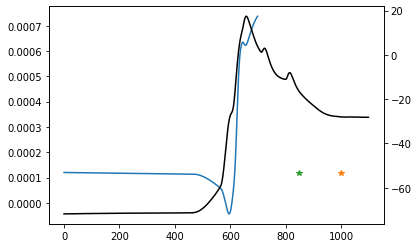

In [64]:
seg = 90
lower_bound = 150
#upper_bound = 
plt.plot(-(hva['report']['biophysical']['data'][lower_bound-100:lower_bound+600,seg]+\
         lva['report']['biophysical']['data'][lower_bound-100:lower_bound+600,seg]+\
         ih['report']['biophysical']['data'][lower_bound-100:lower_bound+600,seg]))
plt.plot(1000,-(hva['report']['biophysical']['data'][lower_bound,seg]+\
         lva['report']['biophysical']['data'][lower_bound,seg]+\
         ih['report']['biophysical']['data'][lower_bound,seg]),'*')

plt.plot(1000-lower_bound,-(hva['report']['biophysical']['data'][150,seg]+\
         lva['report']['biophysical']['data'][150,seg]+\
         ih['report']['biophysical']['data'][150,seg]),'*')

plt.twinx()
plt.plot(v['report']['biophysical']['data'][lower_bound-100:lower_bound+1000,seg],color='k')

----------

In [65]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index() 

In [66]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,39,))
    
    edges_apic=np.quantile(segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                       (segs_ca_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='apic')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                ca_apic[e] += x2
                
                
            
            actual_spktimes.append(i)
        c = i
    return ca_apic

In [67]:
ca_apic = get_ca_sta(segs_ca_df, spktimes)

In [68]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

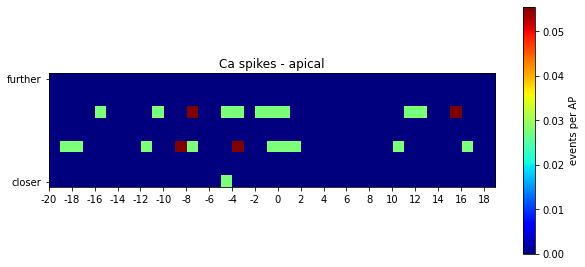

In [69]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca spikes - apical')
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.colorbar(label='events per AP')
plt.yticks(ticks=[0,9],labels=['further','closer'])

plt.show()

----------------------

In [70]:
#apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

#basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


In [ ]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index: #(segs.Type=='dend')|(segs.Type=='apic')
    #print(p)
    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc

    #print(legit_uc)
    #print(legit_dc)
    
    if (len(legit_uc_iso)!=0) & (np.min(nmda['report']['biophysical']['data'][:,p])!=0):
        print('if')
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['report']['biophysical']['data'])


        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
        #print(nmda_df.mag)
    
    else:
        #print('else')
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))


#display(nmda_df.mag.to_string())


#min(nmda_df.mag)

In [72]:
#nmda_df.to_csv('nmda_df.csv')
#nmda_df = pd.read_csv('nmda_df.csv')


In [73]:
#mda_df.mag <= -0.000000001

In [74]:
#segs_nmda_df[:]

In [75]:
#nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [94]:
segs_nmda_df = segs.join(nmda_df.set_index('segmentID')).reset_index()

In [95]:
segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]

,index,BMTK ID,X,Type,Sec ID,Distance,Coord X,Coord Y,Coord Z,Elec_distance,Elec_distanceQ,segmentID,nmda_lower_bound,nmda_upper_bound,mag
16,16,16,0.7500,dend,9,108.000005,7.450397e+01,-63.664421,0.000000,0.137137,4,1,10517,10707,-534.944419
17,17,17,0.0625,dend,9,149.250007,9.839738e+01,-84.081583,0.000000,0.069537,4,2,575,620,-8.166650
18,17,17,0.0625,dend,9,149.250007,9.839738e+01,-84.081583,0.000000,0.069537,4,2,1519,1576,-276.900571
19,17,17,0.0625,dend,9,149.250007,9.839738e+01,-84.081583,0.000000,0.069537,4,2,2337,2430,-246.034360
20,17,17,0.0625,dend,9,149.250007,9.839738e+01,-84.081583,0.000000,0.069537,4,2,5999,6016,-3.006697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,47,47,0.8125,dend,12,328.000014,-4.441018e-14,-206.584549,-241.757782,0.021122,0,8,1411,1490,-149.717914
224,47,47,0.8125,dend,12,328.000014,-4.441018e-14,-206.584549,-241.757782,0.021122,0,8,4130,4158,-52.880652
225,47,47,0.8125,dend,12,328.000014,-4.441018e-14,-206.584549,-241.757782,0.021122,0,8,4792,4841,-24.040502
226,47,47,0.8125,dend,12,328.000014,-4.441018e-14,-206.584549,-241.757782,0.021122,0,8,6258,6438,-233.600768


In [78]:
#min(segs_nmda_df.mag)

In [79]:
#segs_nmda_df[(segs_nmda_df.mag<-0.0001)]

In [96]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.00001)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [97]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spktimes)

In [98]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [99]:
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

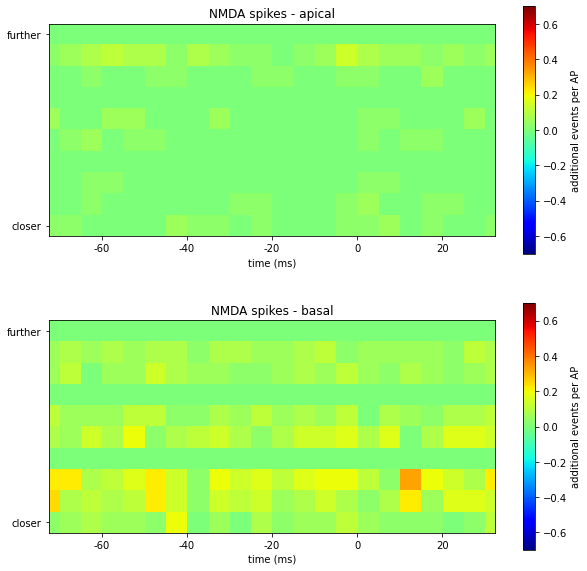

In [100]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.7,vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.7, vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

In [ ]:
for i in np.arange(0,10):
    plt.plot(np.arange(-40,95,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [ ]:
# segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

In [ ]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['Coord X'], segs['Coord Y'], 'b.')
plt.plot(segs.loc[0,'Coord X'], segs.loc[0,'Coord Y'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'Coord X'], segs.loc[ind,'Coord Y'], 'r*',markersize=20)

# for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==2)]['Sec ID'].unique():
#     plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#              segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='r')
    
#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')
    
#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
plt.ylim(-25,50)
plt.xlim(-150,150)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.plot(f['report']['biophysical']['data'][:,119],color='b')
# plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
# plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

# plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
# plt.plot(f['report']['biophysical']['data'][:,0],'k')
# plt.twinx()
# plt.plot(h['report']['biophysical']['data'][:,119],color='r')
# plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
# plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

# plt.xlim(526519-100,526519+1000)

In [ ]:
nmda2 = np.zeros((79,))

for i in spktimes:
    nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
             (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
             (segs_nmda_df.mag<-0.1)&
                (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

    x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
    nmda2 += x2
    
    #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
    #na3 += x3
    
    #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
    #na4 += x4
    
    #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
    #na5 += x5
    

In [ ]:
plt.plot(nmda2)

In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# ind = 1139
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
# plt.ylim(-0.009,0.001)
# plt.xlim(37000,39000)
# plt.ylabel('current (nA)')


In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
# plt.xlim(32000,32400)
# plt.ylim(-0.009,0.001)
# plt.ylabel('current (nA)')


In [ ]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [ ]:
np.arange(-30,31,5).shape

In [ ]:
plt.plot(np.arange(-30,30,5),n)

In [ ]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

In [ ]:
# plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
#          na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

In [ ]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [ ]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
# plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
# plt.xlim(6000,7000)

In [ ]:
# # ind1 = 3 sent to Drew
# ind1 = 2
# e1 = control_inmda[legit_uc_iso[ind1], p]
# e2 = control_inmda[legit_dc_iso[ind1], p]
# x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
# x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
# plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.ylabel('current (nA)')
# plt.ylim(-0.010,0)
# plt.legend(loc='upper center')
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


# for i in np.arange(0,len(bounds)):
#     plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#     plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

In [ ]:
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
# plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

# uc = voltage_criterion(control_v[:,p],-40)[0]


# plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


# center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

# plt.plot([center,center+26],[-80,-80],color='k')
# plt.legend(loc='lower left')

# plt.twinx()
# plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
# #plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
# plt.xlim(center-100,center+100)

# plt.legend(loc='lower right')
# plt.title('{}'.format(legit_uc))

In [ ]:
# p = np.random.choice(segs[segs.Type=='apic'].index)
# for i in spktimes:
#     plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
# plt.vlines(10,-65,0,color='k')
# plt.ylim(-65,0)

In [ ]:
# p = 829#np.random.choice(segs[segs.Type=='dend'].index)
# plt.title('dend {}'.format(p))
# plt.plot(control_v[7200:7700,p],label='dend')
# plt.plot(control_v[7200:7700,0],label='soma')
# plt.hlines(-40,0,500)
# plt.twinx()
# plt.plot(control_inmda[7200:7700,p],color='r')
# plt.legend()

In [ ]:
# control_v[10000,0]

In [ ]:
# plt.hist(control_v[10000,:])

In [ ]:
# plt.plot(control_v[:,1200])
# plt.plot(NMDAblock_v[:,1200])

In [ ]:
# df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [ ]:
# df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

In [ ]:
# df[(df.Distance>900) & (df.Distance<1000)]

In [ ]:
# plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
# plt.xlim(1740,1760)

In [ ]:
# plt.figure(figsize=(10,6))
# plt.scatter(df['Distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
# plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
# plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
# plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
# plt.xlabel('distance from soma')
# plt.ylabel('mean potential of segment (mV)')

In [ ]:
# #plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

# plt.figure(figsize=(10,6))

# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
# plt.xlim(1.75,2)
# plt.xlabel('time (s)')
# plt.ylabel('membrane potential (mV)')